In [1]:
import numpy as np
import scipy.stats
import math
import re
import pandas as pd
import subprocess
import time
import os
import arviz as az
import meamfit_py as meamfit_py15
import matplotlib.pyplot as plt

In [2]:

# Dataframe for recording values at each step
vals = pd.DataFrame(columns=['accepted_b1', 'rejected_b1',
                             'accepted_b2', 'rejected_b2',
                             'accepted_b3', 'rejected_b3',
                             'accepted_b4', 'rejected_b4',
                             'curr_post',
                             'prop_post',
                             'prob',
                             'likelihood',
                             'change_accepted'])
iterations = 10000
meamfit_params = meamfit_py15.read_params_py()

theta = [0,0,0,1]
theta[0] = meamfit_params[1][0][1]
theta[1] = meamfit_params[3][0][1]
theta[2] = meamfit_params[5][0][1]

def likelihood(theta):
    likelihoods = np.exp((-meamfit_py15.meamfit(theta[0], theta[1], theta[2]))/theta[3])
    return likelihoods

#Priors
meam_prior_var = 5
b1_dist = scipy.stats.halfnorm(0,meam_prior_var)
b2_dist = scipy.stats.halfnorm(0,meam_prior_var)
b3_dist = scipy.stats.halfnorm(0,meam_prior_var)
b4_dist = scipy.stats.gamma(2,0.5)


# Functions needed for prob calc at each step
def prior(theta):
    b1_prior = b1_dist.pdf(theta[0])
    b2_prior = b2_dist.pdf(theta[1])
    b3_prior = b3_dist.pdf(theta[2])
    b4_prior = b4_dist.pdf(theta[3])
    return b1_prior * b2_prior * b3_prior * b4_prior


def posterior(theta):
    return likelihood(theta) * prior(theta)

# Current posterior
curr_post = posterior(theta)
# MCMC Loop
for i in range(1, iterations):
    if i % 100 == 0:
        print("---------------- \n {}".format(i))
    # Proposed step
    theta_proposal = [np.random.normal(theta[0], 0.25),
                      np.random.normal(theta[1], 0.25),
                      np.random.normal(theta[2], 0.25),
                      np.random.normal(theta[3], 0.25)]
    # Proposed posterior
    prop_post = posterior(theta_proposal)
    # If prob > 1 the proposed theta is accepted, if not, value between 0 and 1 is the prob of acceptance
    prob = (prop_post / curr_post)

    if np.random.uniform(0,1) < prob and prob > 0:
        vals = vals.append({'accepted_b1'   :theta_proposal[0], 'rejected_b1'    :theta[0],
                            'accepted_b2'   :theta_proposal[1], 'rejected_b2'    :theta[1],
                            'accepted_b3'   :theta_proposal[2], 'rejected_b3'    :theta[2],
                            'accepted_b4'   :theta_proposal[3], 'rejected_b4'    :theta[3],
                            'curr_post'     :curr_post,
                            'prop_post'         :prop_post,
                            'prob'         :prob,
                            'likelihood'    :likelihood(theta_proposal),
                            'change_accepted': True}, ignore_index=True)
        theta = theta_proposal
        curr_post = prop_post
    else:
        vals = vals.append({'accepted_b1'   :theta[0], 'rejected_b1'     :theta_proposal[0],
                            'accepted_b2'   :theta[1], 'rejected_b2'     :theta_proposal[1],
                            'accepted_b3'   :theta[2], 'rejected_b3'     :theta_proposal[2],
                            'accepted_b4'   :theta[3], 'rejected_b4'     :theta_proposal[3],
                            'curr_post'     :curr_post,
                            'prop_post'         :prop_post,
                            'prob'         :prob,
                            'likelihood'    :likelihood(theta),
                            'change_accepted': False}, ignore_index=True)

---------------- 
 100
---------------- 
 200
---------------- 
 300
---------------- 
 400
---------------- 
 500
---------------- 
 600
---------------- 
 700
---------------- 
 800
---------------- 
 900
---------------- 
 1000
---------------- 
 1100
---------------- 
 1200
---------------- 
 1300
---------------- 
 1400
---------------- 
 1500
---------------- 
 1600
---------------- 
 1700
---------------- 
 1800
---------------- 
 1900
---------------- 
 2000
---------------- 
 2100
---------------- 
 2200
---------------- 
 2300
---------------- 
 2400
---------------- 
 2500
---------------- 
 2600
---------------- 
 2700
---------------- 
 2800
---------------- 
 2900
---------------- 
 3000
---------------- 
 3100
---------------- 
 3200
---------------- 
 3300
---------------- 
 3400
---------------- 
 3500
---------------- 
 3600
---------------- 
 3700
---------------- 
 3800
---------------- 
 3900
---------------- 
 4000
---------------- 
 4100
---------------- 
 4200
-

In [3]:
meamfit_py15.end_mpi()
vals.to_csv('run14.csv')
vals=pd.read_csv('run14.csv')

'''
def plot_converg(accept, reject ,string, predicted):
    ax = plt.subplot(1,1,1)
    plt.grid(which='both', color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.4)
    ax.plot(range(1,len(accept)+1), accept, color = 'black',  marker=None, alpha=0.8)
    plt.title("coefficient {} (starting {})".format(string, predicted))
    plt.scatter(range(1,len(accept)+1), reject, marker='x', alpha=0.18, color='red')
    plt.xlabel('no. iterations')
    plt.ylabel(string)
    ax.annotate(string, xy=(range(1,len(accept)+1),accept),
                xytext=(5,0),
                xycoords=(ax.get_xaxis_transform(),
                          ax.get_yaxis_transform()),
                textcoords='offset points',
                va='center')

    plt.legend(["accepted", "rejected"],
               loc ="lower right")
    plt.show()
    plt.draw()

import seaborn as sns
'''
burn_in =0
import matplotlib.pyplot as plt

In [4]:
vals

Unnamed: 0  accepted_b1  rejected_b1  accepted_b2  rejected_b2  \
0              0     2.133622     2.401008     3.366306     3.879403   
1              1     2.339202     2.133622     3.566519     3.366306   
2              2     2.045522     2.339202     3.393965     3.566519   
3              3     2.117798     2.045522     3.374767     3.393965   
4              4     2.378480     2.117798     3.253767     3.374767   
...          ...          ...          ...          ...          ...   
9994        9994     0.529575     0.823542     1.504343     1.525661   
9995        9995     0.473975     0.529575     1.192027     1.504343   
9996        9996     0.293703     0.473975     1.727223     1.192027   
9997        9997     0.233389     0.293703     1.552718     1.727223   
9998        9998     0.300658     0.233389     1.524567     1.552718   

      accepted_b3  rejected_b3  accepted_b4  rejected_b4  curr_post  \
0        3.045039     2.983669     0.927211     1.000000   0.000629   
1        3.188765     3.045039     1.007836     0.927211   0.000339   
2        3.205251     3.188765     1.186193     1.007836   0.000432   
3        3.281286     3.205251     0.864681     1.186193   0.000726   
4        3.324939     3.281286     1.066667     0.864681   0.000347   
...           ...          ...          ...          ...        ...   
9994     2.408936     2.308154     2.635677     2.473452   0.000441   
9995     2.349472     2.408936     1.905076     2.635677   0.000464   
9996     2.268230     2.349472     2.297776     1.905076   0.000469   
9997     2.734252     2.268230     2.116871     2.297776   0.000445   
9998     2.858620     2.734252     2.105266     2.116871   0.000843   

      prop_post      prob  likelihood  change_accepted  
0      0.000339  0.539083    0.495517             True  
1      0.000432  1.272560    0.613050             True  
2      0.000726  1.680564    0.868932             True  
3      0.000347  0.478331    0.574626             True  
4      0.000144  0.413912    0.189810             True  
...         ...       ...         ...              ...  
9994   0.000464  1.051811    0.534876             True  
9995   0.000469  1.011152    0.386680             True  
9996   0.000445  0.947725    0.433167             True  
9997   0.000843  1.895398    0.788591             True  
9998   0.000537  0.637364    0.506908             True  

[9999 rows x 14 columns]

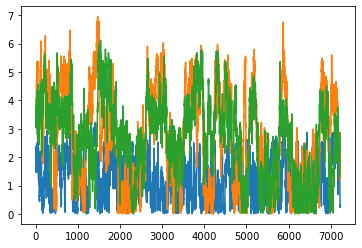

In [5]:
df = vals[vals["change_accepted"] == True]
# df = vals
plt.plot(df["accepted_b1"].values)
plt.plot(df["accepted_b2"].values)
plt.plot(df["accepted_b3"].values)
plt.show()

In [6]:
prior1 = scipy.stats.halfnorm(0,meam_prior_var).rvs(size=df.shape[0])
prior2 = scipy.stats.halfnorm(0,meam_prior_var).rvs(size=df.shape[0])
prior3 = scipy.stats.halfnorm(0,meam_prior_var).rvs(size=df.shape[0])
prior4 = np.random.gamma(2,0.5,size=df.shape[0])

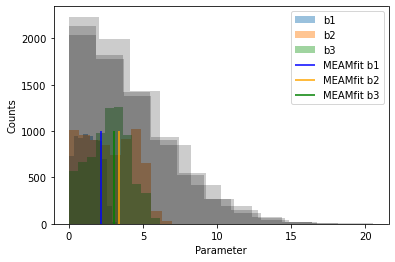

In [7]:
plt.hist(df["accepted_b1"].values,alpha=0.45,label="b1")
plt.hist(df["accepted_b2"].values,alpha=0.45,label="b2")
plt.hist(df["accepted_b3"].values,alpha=0.45,label="b3")
plt.vlines(df["accepted_b1"].iloc[0], 0, 1000, colors='blue', linestyles='solid', label='MEAMfit b1')
plt.vlines(df["accepted_b2"].iloc[0], 0, 1000, colors='orange', linestyles='solid', label='MEAMfit b2')
plt.vlines(df["accepted_b3"].iloc[0], 0, 1000, colors='green', linestyles='solid', label='MEAMfit b3')
plt.hist(prior1,color="black",alpha=0.2)
plt.hist(prior2,color="black",alpha=0.2)
plt.hist(prior3,color="black",alpha=0.2)
plt.legend()
plt.xlabel("Parameter")
plt.ylabel("Counts")
plt.show()

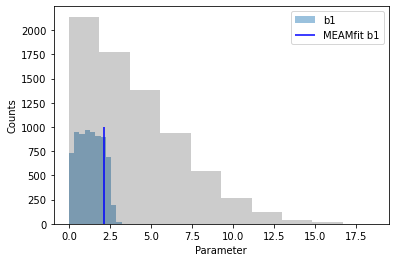

In [8]:
plt.hist(df["accepted_b1"].values,alpha=0.45,label="b1")
plt.vlines(df["accepted_b1"].iloc[0], 0, 1000, colors='blue', linestyles='solid', label='MEAMfit b1')
plt.hist(prior1,color="black",alpha=0.2)
plt.legend()
plt.xlabel("Parameter")
plt.ylabel("Counts")
plt.show()

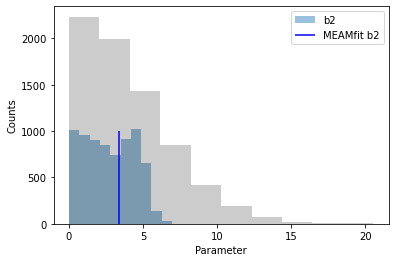

In [17]:
plt.hist(df["accepted_b2"].values,alpha=0.45,label="b2")
plt.vlines(df["accepted_b2"].iloc[0], 0, 1000, colors='blue', linestyles='solid', label='MEAMfit b2')
plt.hist(prior2,color="black",alpha=0.2)
plt.legend()
plt.xlabel("Parameter")
plt.ylabel("Counts")
plt.show()

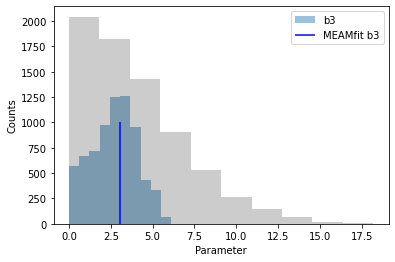

In [18]:
plt.hist(df["accepted_b3"].values,alpha=0.45,label="b3")
plt.vlines(df["accepted_b3"].iloc[0], 0, 1000, colors='blue', linestyles='solid', label='MEAMfit b3')
plt.hist(prior3,color="black",alpha=0.2)
plt.legend()
plt.xlabel("Parameter")
plt.ylabel("Counts")
plt.show()

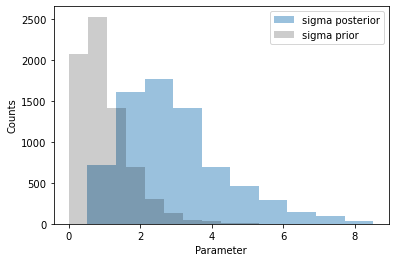

In [11]:
plt.hist(df["accepted_b4"].values,alpha=0.45,label="sigma posterior")
plt.hist(prior4,color="black",alpha=0.2, label="sigma prior")
plt.legend()
plt.xlabel("Parameter")
plt.ylabel("Counts")
plt.show()

In [12]:
df_acc = df[["accepted_b1","accepted_b2","accepted_b3"]]
dict_acc = dict(df_acc)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

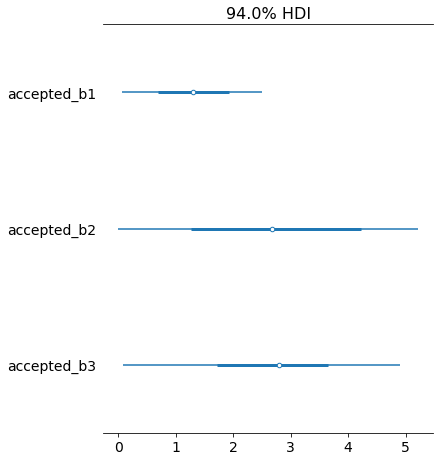

In [13]:
az.plot_forest(dict_acc)

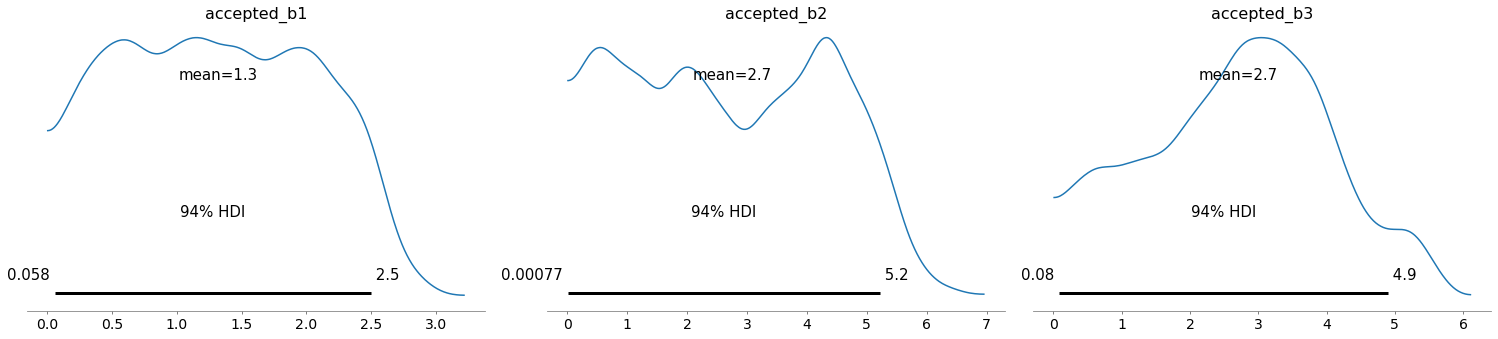

In [14]:
az.plot_posterior(dict_acc)
plt.show()

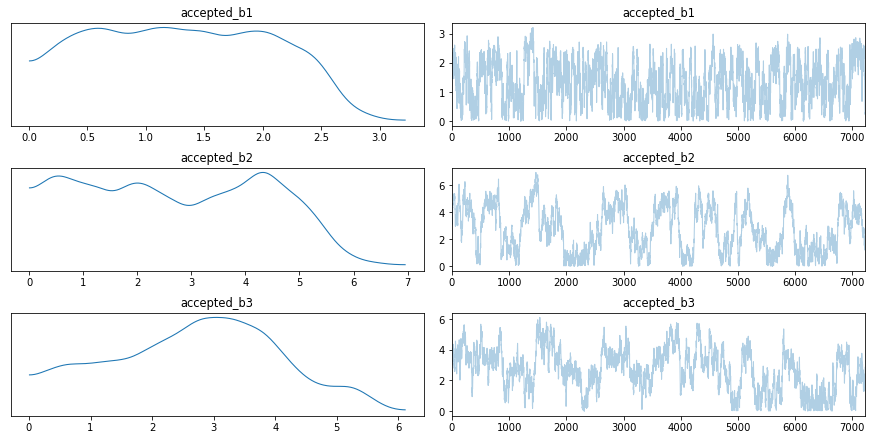

In [15]:
az.plot_trace(dict_acc)
plt.show()

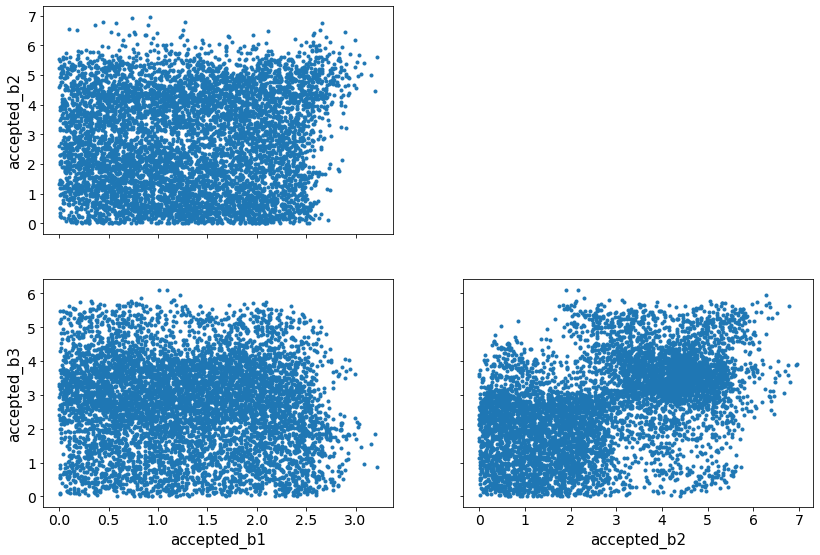

In [16]:
az.plot_pair(
    dict_acc
);

The MCMC looks reasonable. However the parameters from MEAMfit and the distribution from the MCMC are a little inconsistent for parameter 2, and maybe parameter 1 also. Take a closer look at the energy landscape:

In [37]:
#Grid of energy vs parameter, and brut force finding the minimum energy parameters
meamfit_py15.start_mpi()
p1, p2, p3 = np.meshgrid(np.arange(0, 5.1, 0.25),np.arange(0, 5.1, 0.25),np.arange(0, 5.1, 0.25))
grid_energy = np.array([[i,j,k, meamfit_py15.meamfit(i, j, k)] for [i,j,k] in np.array([p1.flatten(), p2.flatten(), p3.flatten()]).T])
print(grid_energy.T[3].argmin())
grid_energy[grid_energy.T[3].argmin()]

5472


array([2.        , 3.        , 3.        , 0.13298695])

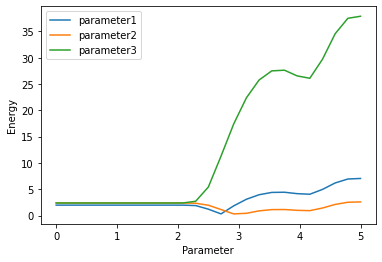

In [38]:
#1D plot of energy landscape about minimums
E_para_df = pd.DataFrame(
    {
     "parameter": np.array([k for k in np.linspace(0,5,25)]),
     "E_p1": np.array([meamfit_py15.meamfit(2, 2, k) for k in np.linspace(0,5,25)]),
     "E_p2": np.array([meamfit_py15.meamfit(2, j, 3) for j in np.linspace(0,5,25)]),
     "E_p3": np.array([meamfit_py15.meamfit(i, 2, 3) for i in np.linspace(0,5,25)]),
    }
)

plt.plot(E_para_df["parameter"],E_para_df["E_p1"],label="parameter1")
plt.plot(E_para_df["parameter"],E_para_df["E_p2"],label="parameter2")
plt.plot(E_para_df["parameter"],E_para_df["E_p3"],label="parameter3")
plt.xlabel("Parameter")
plt.ylabel("Energy")
plt.legend()
plt.show()

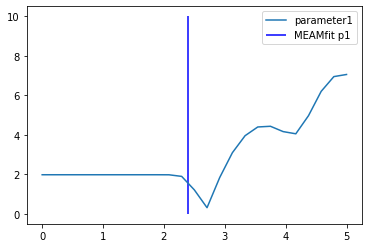

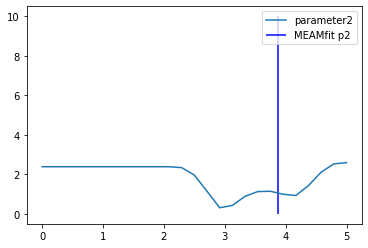

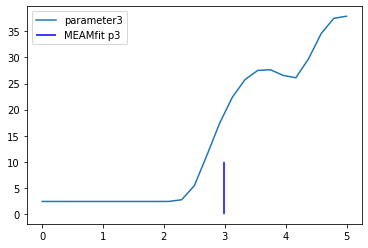

In [39]:
#Check the minimum from grid search is the same as the one from MEAMfit:
meamfit_params = meamfit_py15.read_params_py()

theta = [0,0,0,1]
theta[0] = meamfit_params[1][0][1]
theta[1] = meamfit_params[3][0][1]
theta[2] = meamfit_params[5][0][1]

plt.plot(E_para_df["parameter"],E_para_df["E_p1"],label="parameter1")
plt.vlines(theta[0], 0, 10, colors='blue', linestyles='solid', label='MEAMfit p1')
plt.legend()
plt.show()

plt.plot(E_para_df["parameter"],E_para_df["E_p2"],label="parameter2")
plt.vlines(theta[1], 0, 10, colors='blue', linestyles='solid', label='MEAMfit p2')
plt.legend()
plt.show()

plt.plot(E_para_df["parameter"],E_para_df["E_p3"],label="parameter3")
plt.vlines(theta[2], 0, 10, colors='blue', linestyles='solid', label='MEAMfit p3')
plt.legend()
plt.show()

Questions:
1) Why are MEAMfit and grid search different?

2) Can we give priors that are strictly positive? (What do the parameters mean?)

3) p2 is a bit bi-modal... doesn't bode well

To try:
1) Use the draws to find the undercertainty in the MEAMfit energy estimate

2) More parameters, maybe 10?


